In [1]:
#Importamos las librerías necesarias para llevar a cabo el desarrollo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import date, time, datetime
import ast
sns.set_style("ticks")
import plotly.express as px

Para los estudios que desarrollaremos a continuación, utilizaremos los distintos datasets ubicados en la carpeta [utils.](./data), los cuales se han obtenido mediante consultas API a la base de datos de TMDB (para más información sobre dicha extracción, sugerimos revisar [la documentación de la misma](TMDB_Extraction.ipynb)), en la que hemos incluido todo el detalle.

# HIPÓTESIS 1 - EVOLUCIÓN TEMPORAL DE ESTRENOS:

En primer lugar, mostramos la siguiente función que hemos definido para la validación de fechas de estrenos de películas y series y que utilizaremos a lo largo de este apartado:

In [2]:
def fecha_año_mes_día(fechas):
    '''
    Input:
    - fechas: Serie de fechas informadas en tipo string, las cuales se van a comprobar si recogen
        fechas informadas, coherentes y en el formato "YYYY-MM-DD"
    Ouput:
    - ind_fechas_ko: Lista que contiene los índices de aquellos elementos de la serie 
        introducida como input que no cumplen lo esperado
    '''
    ind_fechas_ko = []
    for i, fecha in enumerate(fechas):
        try: 
            datetime.strptime(fecha, '%Y-%m-%d').date()
        except:
            ind_fechas_ko.append(i)
            continue
    return ind_fechas_ko

## Análisis - Netflix:

### Películas:

In [3]:
#Listado de películas de Netflix España de TMDB
netflix_movies_spain = pd.read_csv(r".\data\netflix_movies.csv")
netflix_movies_spain

,Unnamed: 0,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
0,0,El hoyo 2,The Platform 2,1125510,"[878, 53, 18, 27]",2024-09-27,2554.356,5.700,536,es,False
1,1,The Bad Guys: Haunted Heist,The Bad Guys: Haunted Heist,1329336,"[16, 35]",2024-10-02,944.292,7.400,47,en,False
2,2,Strul,Trouble,1210794,"[28, 35, 80]",2024-10-02,917.854,7.100,77,sv,False
3,3,Bangkok Breaking: ฝ่านรกเมืองเทวดา,Bangkok Breaking: Heaven and Hell,1337309,"[28, 80, 18, 53]",2024-09-26,664.257,6.500,29,th,False
4,4,Joker,Joker,475557,"[80, 53, 18]",2019-10-01,478.179,8.151,25441,en,False
...,...,...,...,...,...,...,...,...,...,...,...
5614,5614,Congreso Anyway,Congreso Anyway,999044,[99],1993-04-01,0.001,0.000,0,nl,False
5615,5615,Homo sapiens. Une nouvelle histoire de l'homme.,Homo Futurus: The Inside Story,920782,"[99, 36]",2005-10-29,0.001,0.000,0,fr,False
5616,5616,Wild Records!,Wild Records!,655704,[],2001-02-03,0.001,0.000,0,pl,False
5617,5617,Не все кошки серы,Not all the Cats are Gray,460784,[],2004-01-01,0.001,0.000,0,ru,False


In [4]:
#Eliminamos la primera columna puesto que no contiene informacción relevante (es el índice duplicado)
netflix_movies_spain.drop("Unnamed: 0", axis=1, inplace=True)

Vamos a verificar que la API no nos haya proporcionado películas duplicadas:

In [5]:
netflix_movies_spain["id"].value_counts().sort_values(ascending=False)

id
2907       2
335983     1
475557     1
4011       1
831815     1
          ..
920782     1
655704     1
460784     1
339510     1
1289045    1
Name: count, Length: 5618, dtype: int64

La película con ID 2907 está repetida, vamos a ver cómo es para determinar qué hacemos con la película que identifica:

In [6]:
netflix_movies_spain[netflix_movies_spain["id"] == 2907]

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
39,The Addams Family,The Addams Family,2907,"[35, 14]",1991-11-22,133.875,7.1,4493,en,False
40,The Addams Family,The Addams Family,2907,"[35, 14]",1991-11-22,149.164,7.1,4493,en,False


Si nos fijamos, vemos que es el campo de ```popularity``` el único que diferencia ambos registros. Puesto que no sabemos cuál es el correcto y ambos valores son muy próximos entre sí, vamos a calcular la media de ambos y se la asignamos a la película (dejando un único registro para ella):

In [7]:
aux_media = (netflix_movies_spain.iloc[39, 5] + netflix_movies_spain.iloc[40, 5])/2
aux_media

141.5195

In [8]:
#Borramos una de las filas de la película duplicada y reseteamos el indexado
netflix_movies_spain.drop(index=39, axis = 0, inplace=True)
netflix_movies_spain = netflix_movies_spain.reset_index(drop=True)

In [9]:
#Calculamos el nuevo índice de la película con la que estamos trabajando
netflix_movies_spain[netflix_movies_spain["id"] == 2907]

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
39,The Addams Family,The Addams Family,2907,"[35, 14]",1991-11-22,149.164,7.1,4493,en,False


In [10]:
#Asignamos la media calculada previamente
netflix_movies_spain.iloc[39,5] = aux_media
netflix_movies_spain.iloc[39,:]

original_title       The Addams Family
title                The Addams Family
id                                2907
genre_ids                     [35, 14]
release_date                1991-11-22
popularity                    141.5195
vote_average                       7.1
vote_count                        4493
original_language                   en
adult                            False
Name: 39, dtype: object

In [11]:
netflix_movies_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5618 entries, 0 to 5617
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     5618 non-null   object 
 1   title              5618 non-null   object 
 2   id                 5618 non-null   int64  
 3   genre_ids          5618 non-null   object 
 4   release_date       5616 non-null   object 
 5   popularity         5618 non-null   float64
 6   vote_average       5618 non-null   float64
 7   vote_count         5618 non-null   int64  
 8   original_language  5618 non-null   object 
 9   adult              5618 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 400.6+ KB


Tal y como podemos ver en la celda anterior: 

- Todas las columnas vienen informadas
- Los campos numéricos son:
    1. ```id``` --> A pesar de estar almacenado como *int64*, es realmente una variable categórica, por lo que no nos interesa calcular ningún estadístico sobre ella. Se trata de la clave por la que se cruza con la información de otros endpoints.
    2. ```popularity``` --> Refleja la popularidad de la película
    3. ```vote_average``` --> Es la media de las votaciones que hay en TMDB
    4. ```vote_count```--> Es el número de votaciones que hay en TMDB

In [ ]:
netflix_movies_spain[["popularity", "vote_average", "vote_count"]].describe()

,popularity,vote_average,vote_count
count,5618.000000,5618.000000,5618.000000
mean,17.279476,5.862582,721.293165
std,47.782660,1.840739,2368.117264
min,0.000000,0.000000,0.000000
25%,2.737000,5.500000,7.000000
50%,7.561000,6.245500,31.000000
75%,18.422750,6.900000,219.750000
max,2554.356000,10.000000,36382.000000


Para analizar el consumo de películas a lo largo del tiempo, vamos a hacerlo a nivel anual. Para ello, tenemos que fijarnos en el campo ```release_date```: Gracias al método **info** aplicado al principio, sabemos que se trata de un campo que es de tipo *str*. A continuación, vamos a verificar que todas las fechas:

1. Vienen informadas
2. En el formato *YYYY-MM-DD*
3. No son incoherentes (por ejemplo, no tenemos un 45 de enero, un 30 de febrero...)

Como ya hemos comentado, para analizar todo esto, lo hacemos mediante la función ***fecha_año_mes_día***  definida [al principio del notebook](#función-para-validar-fechas).

In [13]:
#Analizamos las fechas de lanzamiento de las películas de Netflix
netflix_movies_ko_dates = fecha_año_mes_día(netflix_movies_spain["release_date"])
netflix_movies_ko_dates

[4124, 5281]

In [ ]:
#Imprimimos por pantalla las películas cuyas fechas no cumplen alguna de las 3 condiciones planteadas previamente para
#ser consideradas como correctas
netflix_movies_spain.iloc[netflix_movies_ko_dates,:]

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
4124,"Martin Matte : La vie, la mort... eh la la..!","Martin Matte : La vie, la mort... eh la la..!",639263,[35],NaN,3.753,7.5,3,fr,False
5281,Wilder Planet: Gefahr für Lissabon,Wild Planet – Lisbon in Jeopardy,1037792,[99],NaN,0.349,0.0,0,en,False


Tal y como se puede ver, el problema está en que las sus fechas de lanzamiento vienen vacías. No obstante, si nos fijamos, una de ellas no ha sido votada por nadie (```vote_count``` = 0), y la otra, sólo ha sido votada por tres personas y sus popularidad en la plataforma tampoco es alta. Por ello, procedemos a borrar dichos registros de nuestro análisis, puesto que nos nos van a aportar información relevante.

In [15]:
netflix_movies_spain.drop(index=netflix_movies_ko_dates, axis = 0, inplace=True)
netflix_movies_spain = netflix_movies_spain.reset_index(drop=True)

In [16]:
netflix_movies_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5616 entries, 0 to 5615
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     5616 non-null   object 
 1   title              5616 non-null   object 
 2   id                 5616 non-null   int64  
 3   genre_ids          5616 non-null   object 
 4   release_date       5616 non-null   object 
 5   popularity         5616 non-null   float64
 6   vote_average       5616 non-null   float64
 7   vote_count         5616 non-null   int64  
 8   original_language  5616 non-null   object 
 9   adult              5616 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 400.5+ KB


In [ ]:
#Mediante la función pd.to_datetime convertimos el campo "release" de tipo string a uno de tipo fecha
#Gracias a dt.year, nos quedamos únicamente con el año correspondiente a esa fecha
#Agrupamos por año y ordenamos cronológicamente
netflix_movies_spain_year = netflix_movies_spain.groupby(pd.to_datetime(netflix_movies_spain["release_date"]).dt.year)["id"].count().sort_index()
netflix_movies_spain_year

release_date
1913      1
1917      1
1918      1
1919      2
1920      2
       ... 
2020    472
2021    495
2022    553
2023    482
2024    241
Name: id, Length: 105, dtype: int64

### Series:

Repetimos los pasos que hemos llevado a cabo para las películas:

In [ ]:
#Listado de series de Netflix España de TMDB
netflix_series_spain = pd.read_csv(r".\data\netflix_series.csv")
netflix_series_spain.drop("Unnamed: 0", axis=1, inplace=True)
netflix_series_spain.head()

,original_name,name,id,genre_ids,first_air_date,popularity,vote_average,vote_count,original_language,adult
0,Prison Break,Prison Break,2288,"[10759, 80, 18]",2005-08-29,985.135,8.079,5044,en,False
1,Outer Banks,Outer Banks,100757,"[10759, 18, 9648]",2020-04-15,1165.631,8.400,887,en,False
2,七つの大罪 黙示録の四騎士,The Seven Deadly Sins: Four Knights of the Apo...,218843,"[16, 10759, 10765]",2023-10-08,534.912,8.700,113,ja,False
3,Monsters,Monsters,225634,"[18, 80]",2024-09-19,721.391,7.586,187,en,False
4,Klass 95: El poder de la belleza,KLASS 95: The Power of Beauty,262252,"[18, 35, 10751]",2024-08-20,388.277,6.800,6,es,False


Vamos a verificar que la API no nos haya proporcionado series duplicadas:

In [19]:
netflix_series_spain["id"].value_counts().sort_values(ascending=False)

id
2288      1
46952     1
60574     1
95479     1
218843    1
         ..
211177    1
253682    1
215052    1
121657    1
231382    1
Name: count, Length: 2486, dtype: int64

A diferencia con las películas, no tenemos que quitar ningún duplicado de serie, por lo que proseguimos con el análisis:

In [20]:
netflix_series_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2486 entries, 0 to 2485
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_name      2486 non-null   object 
 1   name               2486 non-null   object 
 2   id                 2486 non-null   int64  
 3   genre_ids          2486 non-null   object 
 4   first_air_date     2482 non-null   object 
 5   popularity         2486 non-null   float64
 6   vote_average       2486 non-null   float64
 7   vote_count         2486 non-null   int64  
 8   original_language  2486 non-null   object 
 9   adult              2486 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 177.4+ KB


Tal y como podemos ver en la celda anterior: 

- Todas las columnas vienen informadas, excepto ```first_air_date```
- Los campos numéricos son:
    1. ```id``` --> Misma conclusión que para los identificadores de las películas
    2. ```popularity``` --> Refleja la popularidad de la película
    3. ```vote_average``` --> Es la media de las votaciones que hay en TMDB
    4. ```vote_count```--> Es el número de votaciones que hay en TMDB

In [21]:
netflix_series_spain[["popularity", "vote_average", "vote_count"]].describe()

,popularity,vote_average,vote_count
count,2486.000000,2486.000000,2486.000000
mean,36.284239,6.895527,296.670957
std,70.581639,1.415147,1087.417183
min,0.002000,0.000000,0.000000
25%,7.280000,6.500000,12.000000
50%,15.091500,7.100000,39.000000
75%,34.736500,7.700000,146.000000
max,1165.631000,10.000000,17559.000000


Para analizar el consumo de series a lo largo del tiempo, vamos a hacerlo a nivel anual. Para ello, tenemos que fijarnos en el campo ```first_air_date```: Igual que para las películas, sabemos que se trata de un campo que es de tipo *str* y realizamos los mismos análisis que antes, mediante la función ***fecha_año_mes_día***  definida [al principio del notebook](#función-para-validar-fechas).

In [22]:
netflix_series_ko_dates = fecha_año_mes_día(netflix_series_spain["first_air_date"])
netflix_series_ko_dates

[2278, 2381, 2394, 2434]

In [23]:
netflix_series_spain.iloc[netflix_series_ko_dates, :]

,original_name,name,id,genre_ids,first_air_date,popularity,vote_average,vote_count,original_language,adult
2278,더 글로리,더 글로리,272659,"[18, 9648]",NaN,4.260,0.0,0,ko,False
2381,حب بين السطور,Love between the lines,232944,[],NaN,1.629,10.0,2,en,False
2394,Кордон,Cordon,253741,[18],NaN,1.505,0.0,0,ru,False
2434,Teen Titans Go! The Night Begins to Shine,Teen Titans Go! The Night Begins to Shine,231914,[16],NaN,1.403,0.0,0,en,False


Tal y como podemos ver, las fechas vienen vacías e, igual que antes, por su poca aportación al estudio que estamos realizando (ninguna de las series ha sido votada por los usuarios excepto una; la cual sólo ha tenido dos votos, y su popularidad en la plataforma es baja), procedemos a borrar dichos registros de nuestro análisis:

In [24]:
netflix_series_spain.drop(index=netflix_series_ko_dates, axis = 0, inplace=True)
netflix_series_spain = netflix_series_spain.reset_index(drop=True)
netflix_series_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2482 entries, 0 to 2481
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_name      2482 non-null   object 
 1   name               2482 non-null   object 
 2   id                 2482 non-null   int64  
 3   genre_ids          2482 non-null   object 
 4   first_air_date     2482 non-null   object 
 5   popularity         2482 non-null   float64
 6   vote_average       2482 non-null   float64
 7   vote_count         2482 non-null   int64  
 8   original_language  2482 non-null   object 
 9   adult              2482 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 177.1+ KB


In [25]:
#Agrupamos por año y ordenamos cronológicamente
netflix_series_spain_year = netflix_series_spain.groupby(pd.to_datetime(netflix_series_spain["first_air_date"]).dt.year)["id"].count().sort_index()
netflix_series_spain_year

first_air_date
1966      2
1969      1
1973      1
1987      2
1989      1
1991      3
1992      2
1993      1
1994      1
1995      3
1997      2
1998      3
1999      3
2000      4
2001      8
2002      3
2003      6
2004      7
2005      9
2006      4
2007     13
2008      7
2009     14
2010     16
2011     16
2012     21
2013     25
2014     24
2015     51
2016     96
2017    118
2018    232
2019    267
2020    302
2021    307
2022    381
2023    306
2024    220
Name: id, dtype: int64

### Películas VS Series:

A continuación, usamos un gráfico de líneas para representar la evolución de los estrenos de películas y series de Netflix España:

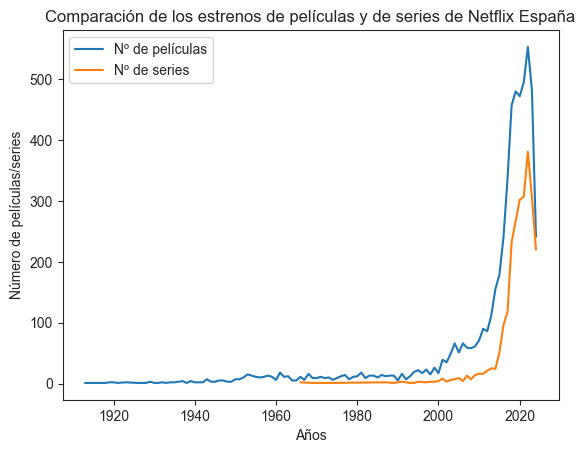

In [26]:
fig, ax = plt.subplots()
plt.title("Comparación de los estrenos de películas y de series de Netflix España")
plt.xlabel("Años")
plt.ylabel("Número de películas/series")
plt.plot(netflix_movies_spain_year, label = "Nº de películas")
plt.plot(netflix_series_spain_year, label = "Nº de series")
plt.legend();

No obstante, esta gráfica puede llevarnos a equívocos puesto que el número total de películas difiere del número total de series. Para poder hacer una **comparación más adecuada**, vamos a dibujar el **porcentaje de crecimiento de estrenos de las películas y de las series**: de este modo, en vez de reflejar información sobre números absolutos, mostraremos **el porcentaje de crecimiento/decrecimiento de estrenos de películas a lo largo del tiempo** (para más información sobre esto, mirar [este enlace](https://blog.datawrapper.de/dualaxis/)).

In [27]:
#Cogemos como punto inicial de referencia el primer valor para las series y las películas
movie_referencia = netflix_movies_spain_year.iloc[0]
serie_referencia = netflix_series_spain_year.iloc[0]
print("Número de películas de Netflix más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma):", movie_referencia, ", del año", netflix_movies_spain_year.index[0])
print("Número de series de Netflix más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma):", serie_referencia, ", del año", netflix_series_spain_year.index[0])

Número de películas de Netflix más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma): 1 , del año 1913
Número de series de Netflix más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma): 2 , del año 1966


In [28]:
#Calculamos los porcentajes de crecimiento de series y películas a lo largo de los años con respecto al año de referencia
porc_crec_movies = (netflix_movies_spain_year/movie_referencia)*100
porc_crec_series = (netflix_series_spain_year/serie_referencia)*100

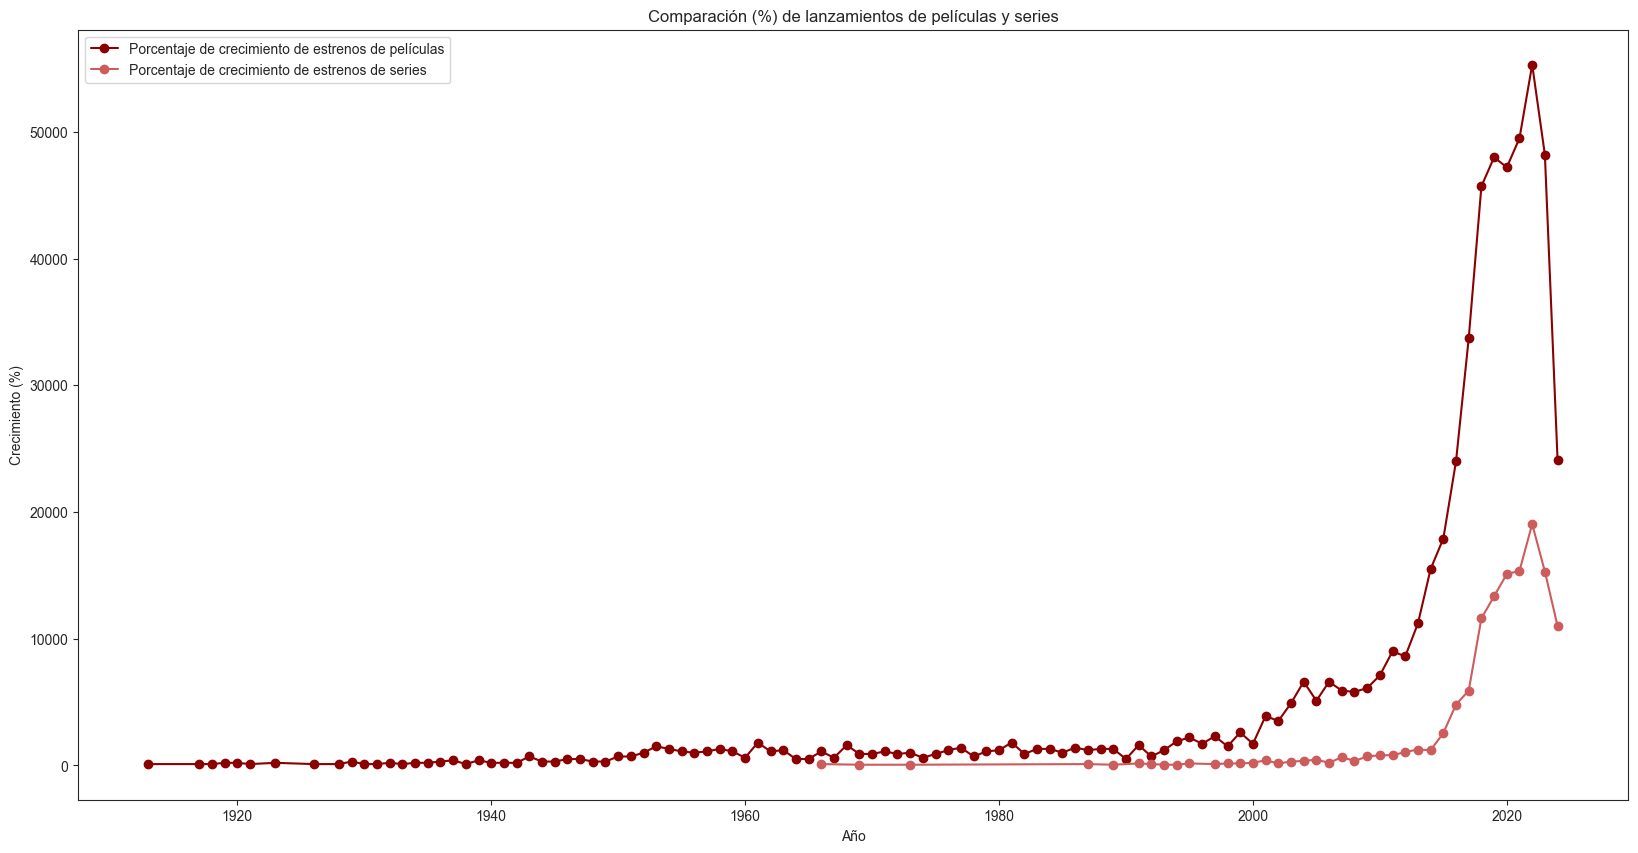

In [29]:
plt.figure(figsize=(20,10))

plt.plot(porc_crec_movies, color='darkred', marker='o', label='Porcentaje de crecimiento de estrenos de películas')
plt.plot(porc_crec_series, color='indianred', marker='o', label='Porcentaje de crecimiento de estrenos de series')
plt.title('Comparación (%) de lanzamientos de películas y series')
plt.xlabel('Año')
plt.ylabel('Crecimiento (%)')
plt.legend(loc = "upper left")
plt.show()

En ambos casos podemos ver que:

- Las series de Netflix más antiguas son más recientes que las películas más antiguas (hay películas de años previos a 1920, mientras que las primeras series datan de años posteriores a los 60).
- Los estrenos tanto de películas como de series se mantuvieron constantes hasta que...
    - El estreno de películas empezó a aumentar en torno al año 2000, habiendo un gran auge unos años más tarde, y el incremento máximo teniendo lugar en torno al 2020, para luego descender.
    - El estreno de series empezó un poco más tarde que el de las películas, siendo unos años antes del 2020 cuando empezó tener un comportamiento ascendente, y alcanzando su pico máximo más o menos a la par que las películas para, igual que estas, empezar a descender. 
    
**Así pues, podemos concluir que el comportamiento de crecida y de bajada del porcentaje de estrenos de ambos recursos audiovisuales es bastante similar, si bien el de las películas es muy superior al de las series**.

## Análisis - Amazon Prime Video:

### Películas:

In [30]:
#Listado de películas de Amazon Prime Video España de TMDB
amazon_movies_spain = pd.read_csv(r".\data\amazon_movies.csv")
amazon_movies_spain

,Unnamed: 0,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
0,0,Terrifier,Terrifier,420634,"[27, 53]",2018-01-25,879.388,6.442,2118,en,False
1,1,Terrifier 2,Terrifier 2,663712,"[27, 53]",2022-10-06,900.390,6.778,1805,en,False
2,2,Joker,Joker,475557,"[80, 53, 18]",2019-10-01,579.469,8.200,25421,en,False
3,3,House of Spoils,House of Spoils,1014661,"[27, 53]",2024-09-21,491.485,5.800,54,en,False
4,4,Culpa mía,My Fault,1010581,"[10749, 18]",2023-06-08,376.118,7.900,2966,es,False
...,...,...,...,...,...,...,...,...,...,...,...
5500,5500,The Otter's Trail,The Otter's Trail,727320,[99],1998-01-01,0.001,0.000,0,es,False
5501,5501,The Iron Forest,The Iron Forest,304499,[99],1998-01-01,0.001,0.000,0,en,False
5502,5502,Puszta - Land of Salt and Sand,Puszta - Land of Salt and Sand,304481,[99],2002-01-01,0.001,0.000,0,en,False
5503,5503,Alpine Lakes - Quiet Beauty,Alpine Lakes - Quiet Beauty,304463,[99],2003-01-01,0.001,0.000,0,en,False


In [31]:
#Eliminamos la primera columna puesto que no contiene informacción relevante (es el índice duplicado)
amazon_movies_spain.drop("Unnamed: 0", axis=1, inplace=True)

Vamos a verificar que la API no nos ha devuelto películas duplicadas:

In [ ]:
amazon_movies_spain["id"].value_counts().sort_values(ascending=False)

id
420634     1
231001     1
1014661    1
1010581    1
603692     1
          ..
727320     1
304499     1
304481     1
304463     1
295575     1
Name: count, Length: 5505, dtype: int64

No tenemos ninguna película duplicada en el catálogo de Amazon puesto que, tal y como se puede ver en la anterior celda, cada uno de los IDs aparece una única vez.

In [33]:
amazon_movies_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5505 entries, 0 to 5504
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     5505 non-null   object 
 1   title              5505 non-null   object 
 2   id                 5505 non-null   int64  
 3   genre_ids          5505 non-null   object 
 4   release_date       5501 non-null   object 
 5   popularity         5505 non-null   float64
 6   vote_average       5505 non-null   float64
 7   vote_count         5505 non-null   int64  
 8   original_language  5505 non-null   object 
 9   adult              5505 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 392.6+ KB


Igual que para las películas de Netflix, analizamos el campo ```release_date``` mediante la función ***fecha_año_mes_día***  definida [al principio del notebook](#función-para-validar-fechas).

In [34]:
amazon_movies_ko_dates = fecha_año_mes_día(amazon_movies_spain["release_date"])
amazon_movies_ko_dates

[2786, 5103, 5111, 5498]

In [ ]:
amazon_movies_spain.iloc[amazon_movies_ko_dates,:]

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
2786,Most Dangerous Game,Most Dangerous Game,599489,"[35, 10749]",NaN,9.363,0.0,0,en,False
5103,Maya,Maya,1254933,[27],NaN,0.348,8.0,1,en,False
5111,Blades in the Darkness,Blades in the Darkness,1022668,"[53, 27]",NaN,0.266,4.8,3,it,False
5498,Sarasate: The Spanish Spirit,Sarasate: The Spanish Spirit,951396,[99],NaN,0.001,0.0,0,en,False


De nuevo, el problema está en que las fechas de lanzamiento vienen vacías, pero debido a la poca interacción del usuario con las películas (incluso inexistente para dos de ellas) y a que tan solo son 4, vamos a descartarlas del análisis.

In [36]:
amazon_movies_spain.drop(index=amazon_movies_ko_dates, axis=0, inplace=True)
amazon_movies_spain = amazon_movies_spain.reset_index(drop=True)

In [37]:
amazon_movies_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5501 entries, 0 to 5500
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_title     5501 non-null   object 
 1   title              5501 non-null   object 
 2   id                 5501 non-null   int64  
 3   genre_ids          5501 non-null   object 
 4   release_date       5501 non-null   object 
 5   popularity         5501 non-null   float64
 6   vote_average       5501 non-null   float64
 7   vote_count         5501 non-null   int64  
 8   original_language  5501 non-null   object 
 9   adult              5501 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 392.3+ KB


In [38]:
#Agrupamos por año y ordenamos cronológicamente
amazon_movies_spain_year = amazon_movies_spain.groupby(pd.to_datetime(amazon_movies_spain["release_date"]).dt.year)["id"].count().sort_index()
amazon_movies_spain_year

release_date
1918      1
1921      1
1924      1
1926      1
1930      2
       ... 
2020    347
2021    426
2022    437
2023    375
2024    114
Name: id, Length: 99, dtype: int64

### Series:

In [39]:
#Listado de series de Amazon Prime Video España de TMDB
amazon_series_spain = pd.read_csv(r".\data\amazon_series.csv")
amazon_series_spain.drop("Unnamed: 0", axis=1, inplace=True)
amazon_series_spain.head()

,original_name,name,id,genre_ids,first_air_date,popularity,vote_average,vote_count,original_language,adult
0,The Lord of the Rings: The Rings of Power,The Lord of the Rings: The Rings of Power,84773,"[10759, 10765, 18]",2022-09-01,1422.839,7.351,2941,en,False
1,Law & Order: Special Victims Unit,Law & Order: Special Victims Unit,2734,"[80, 18, 9648]",1999-09-20,1070.260,7.923,3797,en,False
2,Supernatural,Supernatural,1622,"[18, 9648, 10765]",2005-09-13,837.182,8.300,7525,en,False
3,House,House,1408,"[18, 9648, 35]",2004-11-16,563.834,8.590,6484,en,False
4,The Good Doctor,The Good Doctor,71712,[18],2017-09-25,560.242,8.483,12332,en,False


Vamos a verificar la unicidad de las series:

In [40]:
amazon_series_spain["id"].value_counts().sort_values(ascending=False)

id
84773     1
764       1
2691      1
57243     1
44006     1
         ..
154753    1
131839    1
273471    1
234673    1
5531      1
Name: count, Length: 1089, dtype: int64

De nuevo, no hay duplicados. Procedemos a analizar las fechas de lanzamiento:

In [41]:
amazon_series_ko_dates = fecha_año_mes_día(amazon_series_spain["first_air_date"])
amazon_series_ko_dates

[880, 910, 968, 978, 994, 999, 1002, 1052, 1054, 1058, 1062, 1086, 1088]

In [42]:
amazon_series_spain.iloc[amazon_series_ko_dates, :]

,original_name,name,id,genre_ids,first_air_date,popularity,vote_average,vote_count,original_language,adult
880,La bruixa avorrida,La bruixa avorrida,208749,"[16, 10759, 10762, 10765]",NaN,3.130,0.0,0,ca,False
910,ソウルメイト,Soul Mate,258063,[18],NaN,2.561,0.0,0,ja,False
968,The Grand Tour,The Grand Tour,273036,[],NaN,1.319,0.0,0,en,False
978,Barbie Dream Squad,Barbie Dream Squad,241205,[16],NaN,1.164,0.0,0,es,False
994,Musti,Musti,30672,[],NaN,0.949,0.0,0,en,False
999,Barbie Summer Adventure,Barbie Summer Adventure,232443,[16],NaN,0.891,0.0,0,en,False
1002,Juanito Jones,Juanito Jones,216309,[10762],NaN,0.850,0.0,0,es,False
1052,Car Patrol of Car City,Car Patrol of Car City,225455,"[10762, 10751, 16]",NaN,0.330,10.0,1,es,False
1054,超级飞侠(2020),超级飞侠(2020),257605,[],NaN,0.306,0.0,0,zh,False
1058,Capelito,Capelito,71522,"[16, 10762]",NaN,0.256,0.0,0,xx,False


De nuevo, el problema reside en la falta de la fecha de estreno. A pesar de que son más casos vacíos que para la plataforma de Netflix, de nuevo optamos por no considerar estos datos en nuestro desarrollo por el bajo interés del usuario para dichas series.

In [43]:
amazon_series_spain.drop(index=amazon_series_ko_dates, axis=0, inplace=True)
amazon_series_spain = amazon_series_spain.reset_index(drop=True)
amazon_series_spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   original_name      1076 non-null   object 
 1   name               1076 non-null   object 
 2   id                 1076 non-null   int64  
 3   genre_ids          1076 non-null   object 
 4   first_air_date     1076 non-null   object 
 5   popularity         1076 non-null   float64
 6   vote_average       1076 non-null   float64
 7   vote_count         1076 non-null   int64  
 8   original_language  1076 non-null   object 
 9   adult              1076 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 76.8+ KB


In [44]:
#Agrupamos por año y ordenamos cronológicamente
amazon_series_spain_year = amazon_series_spain.groupby(pd.to_datetime(amazon_series_spain["first_air_date"]).dt.year)["id"].count().sort_index()
amazon_series_spain_year

first_air_date
1955      1
1958      1
1966      1
1967      1
1971      1
1973      2
1974      1
1976      1
1978      1
1980      1
1981      1
1983      3
1984      2
1985      1
1987      2
1989      2
1990      2
1991      5
1992      2
1993      1
1994      2
1995      1
1996      2
1997      4
1998      4
1999      7
2000      8
2001      6
2002      7
2003     13
2004     13
2005     15
2006      6
2007     14
2008     18
2009     18
2010     21
2011     17
2012     20
2013     23
2014     30
2015     44
2016     52
2017     49
2018     71
2019     55
2020     75
2021     94
2022    123
2023    148
2024     84
Name: id, dtype: int64

### Películas VS Series:

Vamos a dibujar directamente la gráfica en la que vamos a mostrar /**el porcentaje de crecimiento/decrecimiento de estrenos de películas y series a lo largo del tiempo**:

In [45]:
#Cogemos como punto inicial de referencia el primer valor para las series y las películas
movie_referencia_amazon = amazon_movies_spain_year.iloc[0]
serie_referencia_amazon = amazon_series_spain_year.iloc[0]
print("Número de películas de Amazon Prime Video más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma):", movie_referencia_amazon, ", del año", amazon_movies_spain_year.index[0])
print("Número de series de Amazon Prime Video más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma):", serie_referencia_amazon, ", del año", amazon_series_spain_year.index[0])

Número de películas de Amazon Prime Video más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma): 1 , del año 1918
Número de series de Amazon Prime Video más antiguas (en cuanto a fecha de estreno, no a fecha de aparición en la plataforma): 1 , del año 1955


In [46]:
#Calculamos los porcentajes de crecimiento de series y películas a lo largo de los años con respecto al año de referencia
porc_crec_movies_amazon = (amazon_movies_spain_year/movie_referencia_amazon)*100
porc_crec_series_amazon = (amazon_series_spain_year/serie_referencia_amazon)*100

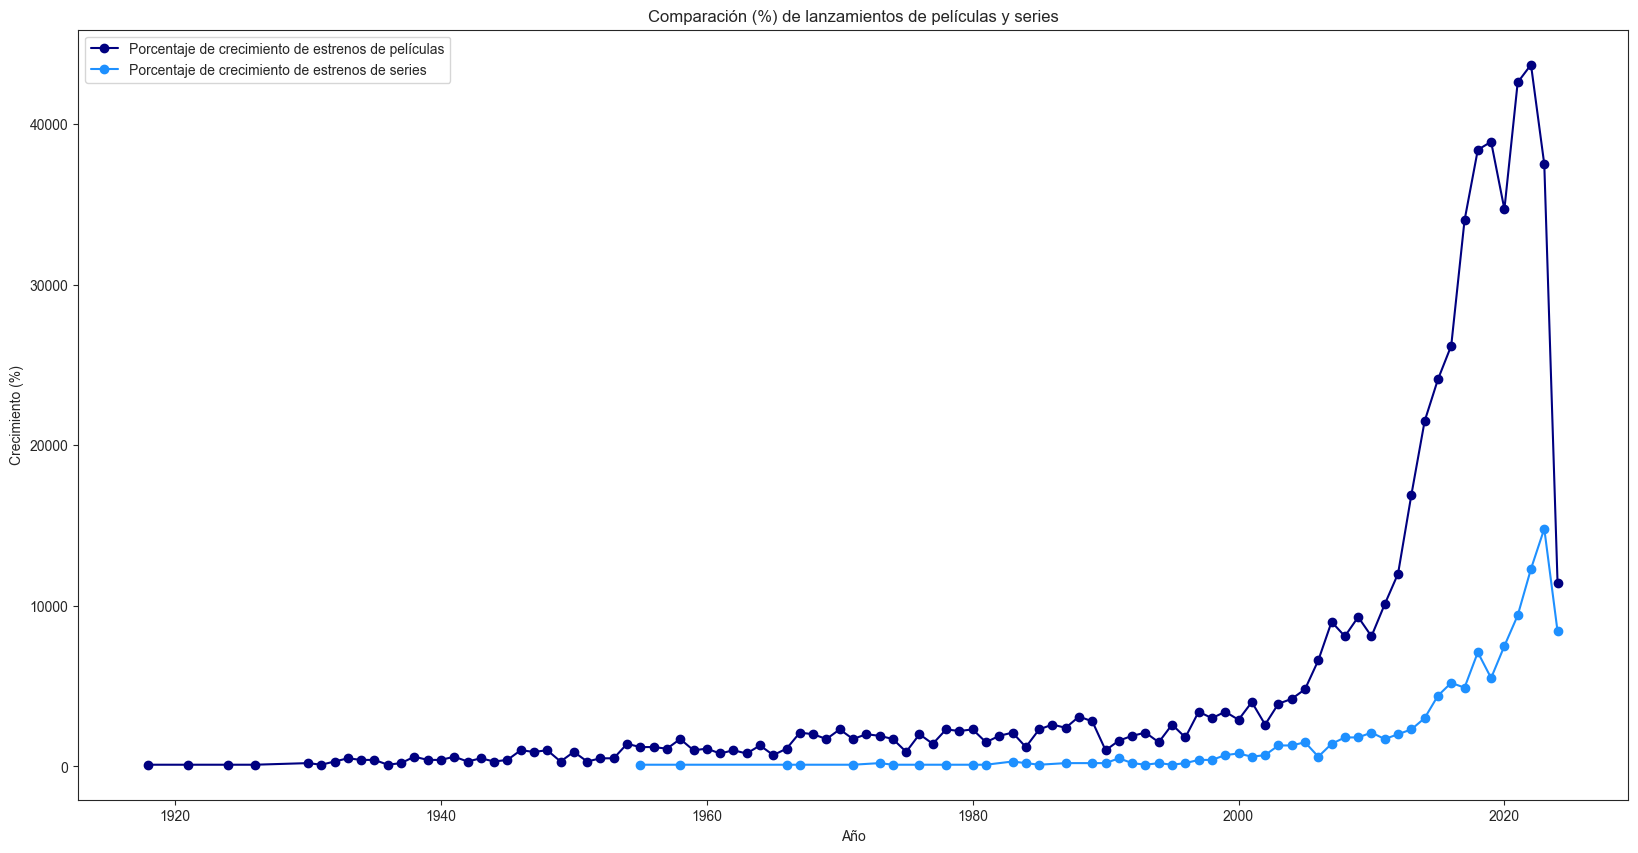

In [47]:
plt.figure(figsize=(20,10))

plt.plot(porc_crec_movies_amazon, color='navy', marker='o', label='Porcentaje de crecimiento de estrenos de películas')
plt.plot(porc_crec_series_amazon, color='dodgerblue', marker='o', label='Porcentaje de crecimiento de estrenos de series')
plt.title('Comparación (%) de lanzamientos de películas y series')
plt.xlabel('Año')
plt.ylabel('Crecimiento (%)')
plt.legend(loc = "upper left")
plt.show()

El comportamiento de dicha gráfica es bastante similar al de la dibujada para Netflix, por lo que las conclusiones son análogas: **El comportamiento de crecida y de bajada del porcentaje de estrenos de ambos recursos audiovisuales es bastante similar, si bien el de las películas es muy superior al de las series**

## Netflix VS Amazon Prime Video:

Para tener una escala adecuada y poder comparar ambas plataformas, dibujamos los resultados en una misma gráfica:

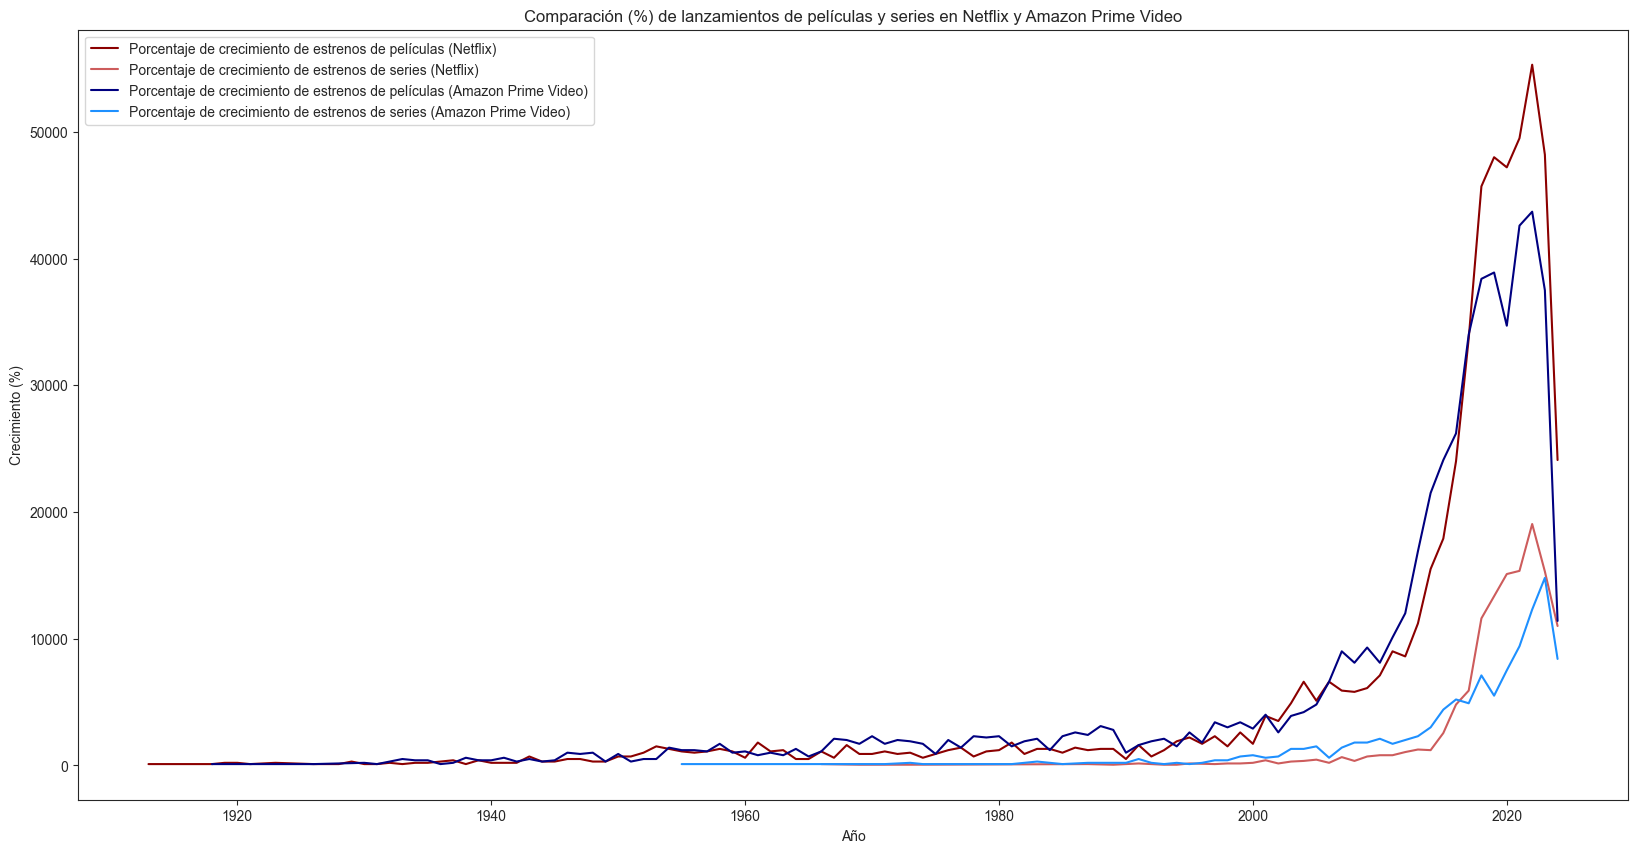

In [48]:
plt.figure(figsize=(20,10))

plt.plot(porc_crec_movies, color='darkred', label='Porcentaje de crecimiento de estrenos de películas (Netflix)')
plt.plot(porc_crec_series, color='indianred', label='Porcentaje de crecimiento de estrenos de series (Netflix)')
plt.plot(porc_crec_movies_amazon, color='navy', label='Porcentaje de crecimiento de estrenos de películas (Amazon Prime Video)')
plt.plot(porc_crec_series_amazon, color='dodgerblue', label='Porcentaje de crecimiento de estrenos de series (Amazon Prime Video)')
plt.title('Comparación (%) de lanzamientos de películas y series en Netflix y Amazon Prime Video')
plt.xlabel('Año')
plt.ylabel('Crecimiento (%)')
plt.legend(loc = "upper left")
plt.show()

Puesto que nuestra hipótesis estaba orientada hacia la actualidad, vamos a restringir la gráfica a los últimos años:

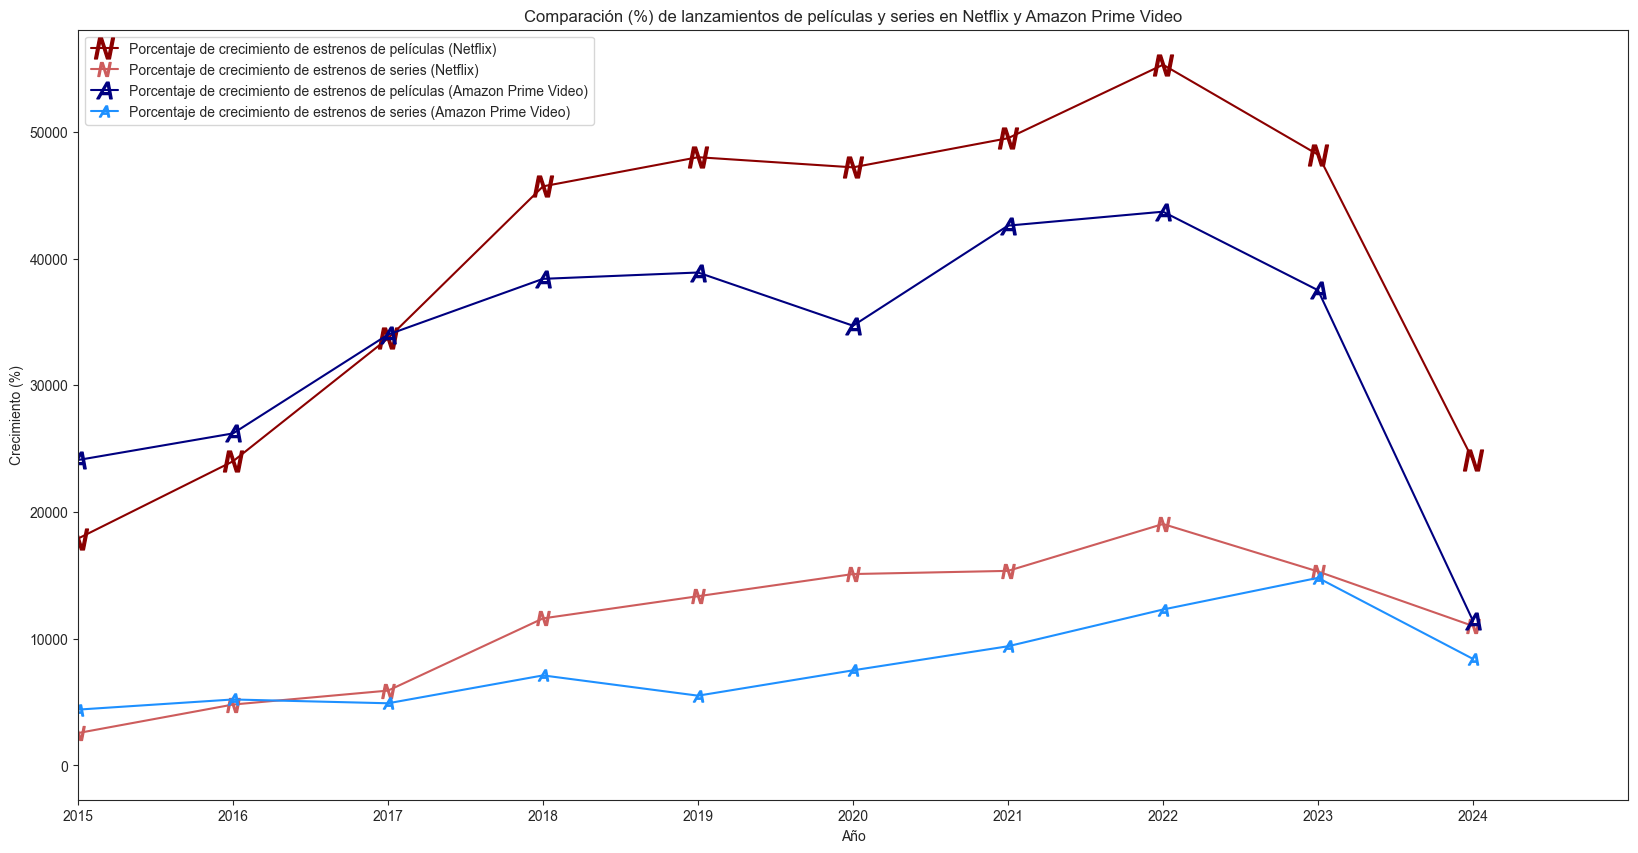

In [49]:
plt.figure(figsize=(20,10))

plt.plot(porc_crec_movies, color='darkred', marker = "$N$" , markersize = 15 , label='Porcentaje de crecimiento de estrenos de películas (Netflix)')
plt.plot(porc_crec_series, color='indianred', marker = "$N$", markersize = 10, label='Porcentaje de crecimiento de estrenos de series (Netflix)')
plt.plot(porc_crec_movies_amazon, color='navy', marker = "$A$" ,markersize = 12,label='Porcentaje de crecimiento de estrenos de películas (Amazon Prime Video)')
plt.plot(porc_crec_series_amazon, color='dodgerblue', marker = "$A$", markersize = 8 , label='Porcentaje de crecimiento de estrenos de series (Amazon Prime Video)')
plt.title('Comparación (%) de lanzamientos de películas y series en Netflix y Amazon Prime Video')
plt.xlabel('Año')
plt.ylabel('Crecimiento (%)')
plt.legend(loc = "upper left")
plt.xticks(list(range(2015, 2025)))
plt.xlim(2015, 2025)
plt.show()

**Finalmente, podemos decir que el año en el que empieza la caída en el estreno de producciones es más o menos general: en torno al 2022-2023.**

# HIPÓTESIS 2 - % DE PRESENCIA DE GÉNEROS:

In [50]:
#Listado de los géneros correspondientes a las películas en TMDB
movies_genres = pd.read_csv(r".\data\tmdb_movie_genres.csv")
movies_genres.drop("Unnamed: 0", axis=1, inplace=True)
movies_genres

,id,name
0,28,Action
1,12,Adventure
2,16,Animation
3,35,Comedy
4,80,Crime
5,99,Documentary
6,18,Drama
7,10751,Family
8,14,Fantasy
9,36,History


In [51]:
#Listado de los géneros correspondientes a las series en TMDB
series_genres = pd.read_csv(r".\data\tmdb_series_genres.csv")
series_genres.drop("Unnamed: 0", axis=1, inplace=True)
series_genres

,id,name
0,10759,Action & Adventure
1,16,Animation
2,35,Comedy
3,80,Crime
4,99,Documentary
5,18,Drama
6,10751,Family
7,10762,Kids
8,9648,Mystery
9,10763,News


Tratamos ambas tablas por separado puesto que, a pesar de que algunos géneros son comunes para películas y series, hay otros que sólo aplican a una de estas obras (*por ejemplo, el género 'Kids' solo está para series*).

## Análisis - Netflix:

### Películas:

Para introducirnos en este nuevo estudio, vamos a echar un vistazo rápido a los primeros registros correspondientes a las películas de Netflix: 

In [52]:
netflix_movies_spain.head(2)

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult
0,El hoyo 2,The Platform 2,1125510,"[878, 53, 18, 27]",2024-09-27,2554.356,5.7,536,es,False
1,The Bad Guys: Haunted Heist,The Bad Guys: Haunted Heist,1329336,"[16, 35]",2024-10-02,944.292,7.4,47,en,False


Si nos fijamos, por ejemplo, en el valor de ```genre_ids``` para la película de *El hoyo 2*, vemos que aparece un listado de números: estos constituyen los identificadores de los géneros correspondientes a dicha obra, cuya equivalencia con cada nombre de género sabemos gracias a la relación **id - nombre** recogida las tablas previas. Puesto que nuestro objetivo es poder analizar de forma individual qué generos predominan en cada una de las plataformas y si difieren entre las películas y las series, necesitamos "desglosar" la información de modo que podamos trabajar con ella, y lo haremos mediante el método ***get_dummies()***:

In [ ]:
#Para poder aplicar correctamente el método, quitamos los corchetes y los espacios en blanco
netflix_movies_spain["genre_ids"] = netflix_movies_spain["genre_ids"].astype(str).replace({'[\[\]\s]': ''}, regex=True)
netflix_movies_spain["genre_ids"]

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
C:\Users\tamar\AppData\Local\Temp\ipykernel_50552\3877176495.py:2: SyntaxWarning: invalid escape sequence '\['
  netflix_movies_spain["genre_ids"] = netflix_movies_spain["genre_ids"].astype(str).replace({'[\[\]\s]': ''}, regex=True)


0       878,53,18,27
1              16,35
2           28,35,80
3        28,80,18,53
4           80,53,18
            ...     
5611              99
5612           99,36
5613                
5614                
5615              35
Name: genre_ids, Length: 5616, dtype: object

Tal y como podemos ver en el output previo, hay películas cuyo género viene sin informar. Vamos a ver cuántas:

In [54]:
netflix_movies_spain["genre_ids"].value_counts().sort_index()

genre_ids
                        103
10402                    16
10402,10749               1
10402,10749,35            1
10402,10751,18,10770      1
                       ... 
99,80                    45
99,80,18                  3
99,80,36                  1
99,80,36,9648             1
99,9648                   2
Name: count, Length: 932, dtype: int64

No vamos a eliminar las películas que tienen el género sin informar porque son bastantes (un total de 103), sino que vamos a asignarles el género de "Unknown": 

**Por no tratarse de celdas vacías sino que tienen un espacio en blanco, a continuación no podemos usar 'fillna' sino 'replace'*

In [55]:
netflix_movies_spain["genre_ids"] = netflix_movies_spain["genre_ids"].astype(str).replace("", "Unknown")
netflix_movies_spain["genre_ids"]

0       878,53,18,27
1              16,35
2           28,35,80
3        28,80,18,53
4           80,53,18
            ...     
5611              99
5612           99,36
5613         Unknown
5614         Unknown
5615              35
Name: genre_ids, Length: 5616, dtype: object

In [56]:
movies_genre_dict = dict(zip(movies_genres["id"].astype(str).replace({'[\[\]\s]': ''}, regex=True), movies_genres["name"]))
#Tenemos que añadir esta nueva clasificación para aquellas películas cuyo género no conocemos
movies_genre_dict["Unknown"] = "Unknown"
movies_genre_dict

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
C:\Users\tamar\AppData\Local\Temp\ipykernel_50552\667482790.py:1: SyntaxWarning: invalid escape sequence '\['
  movies_genre_dict = dict(zip(movies_genres["id"].astype(str).replace({'[\[\]\s]': ''}, regex=True), movies_genres["name"]))


{'28': 'Action',
 '12': 'Adventure',
 '16': 'Animation',
 '35': 'Comedy',
 '80': 'Crime',
 '99': 'Documentary',
 '18': 'Drama',
 '10751': 'Family',
 '14': 'Fantasy',
 '36': 'History',
 '27': 'Horror',
 '10402': 'Music',
 '9648': 'Mystery',
 '10749': 'Romance',
 '878': 'Science Fiction',
 '10770': 'TV Movie',
 '53': 'Thriller',
 '10752': 'War',
 '37': 'Western',
 'Unknown': 'Unknown'}

In [57]:
#Desglosamos los géneros de las películas de Netflix
netflix_movies_dummy = netflix_movies_spain["genre_ids"].str.get_dummies(",")
netflix_movies_dummy = netflix_movies_dummy.rename(columns=movies_genre_dict)
netflix_movies_dummy

,Music,Romance,Family,War,TV Movie,Adventure,Fantasy,Animation,Drama,Horror,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5612,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5613,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5614,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


Así pues, si para cada columna sumamos todos los valores de la misma, tendremos el número de veces que el género que aparece en esa columna ha sido utilizado a la hora de clasificar películas. De este modo, nosotros podemos calcular el **porcentaje** que representa **cada género de forma individual** al **dividir cada** una de esas **sumas** por el **total de géneros informados** en todas las películas (que se corresponde con la suma de todos los elementos de la matriz). Es decir, vamos a calcular cuál es el **género que más veces se ha utilizado para catalogar las películas:**

In [58]:
#Apariciones de cada género para las películas de Netflix
apars_gener_films_netflix= netflix_movies_dummy.sum()
apars_gener_films_netflix

Music               216
Romance             758
Family              416
War                 107
TV Movie            122
Adventure           416
Fantasy             297
Animation           302
Drama              2130
Horror              358
Action              663
Comedy             1998
History             175
Western              25
Thriller            804
Crime               601
Science Fiction     217
Mystery             264
Documentary         993
Unknown             103
dtype: int64

In [ ]:
#Total de géneros informados en todas las películas de Netflix
total_netflix_movies_genre = apars_gener_films_netflix.sum()
total_netflix_movies_genre

10965

In [60]:
porc_netflix_movies_genre = (apars_gener_films_netflix/total_netflix_movies_genre)*100
porc_netflix_movies_genre.sort_values(ascending=False, inplace=True)
porc_netflix_movies_genre

Drama              19.425445
Comedy             18.221614
Documentary         9.056088
Thriller            7.332421
Romance             6.912905
Action              6.046512
Crime               5.481076
Family              3.793890
Adventure           3.793890
Horror              3.264934
Animation           2.754218
Fantasy             2.708618
Mystery             2.407661
Science Fiction     1.979024
Music               1.969904
History             1.595987
TV Movie            1.112631
War                 0.975832
Unknown             0.939352
Western             0.227998
dtype: float64

A continuación, dibujamos un gráfico circular en el que representar esta información: 

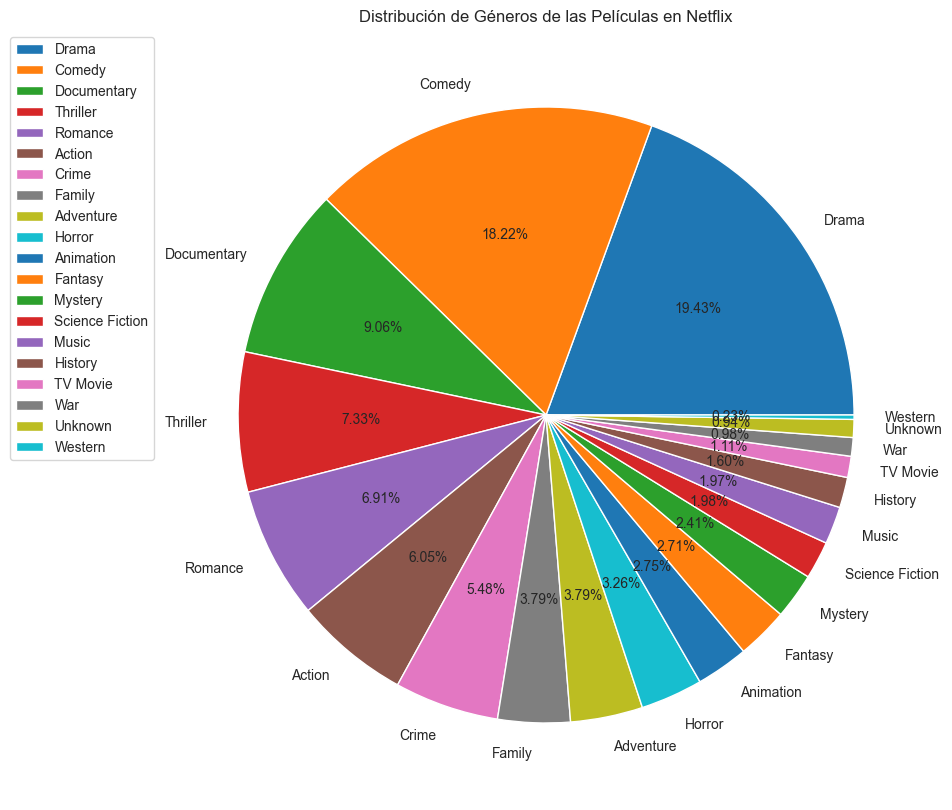

In [61]:
plt.figure(figsize=(10,10))

# declaring data 
data = porc_netflix_movies_genre.values.tolist()
keys = porc_netflix_movies_genre.index.tolist()
  
# plotting data on chart 
plt.pie(data, labels=keys,autopct='%.2f%%') 
  
plt.title("Distribución de Géneros de las Películas en Netflix")
plt.legend(loc = "best", bbox_to_anchor=(0, 1), fontsize='medium')
# displaying chart 
plt.show()

La visualización de dicho gráfico es bastante difícil por la cantidad de géneros que hay. Consecuentemente, para poder visualizar mejor el gráfico anterior, vamos a agrupar dentro de la categoría de "Otros", aquellos géneros cuyo porcentaje sea inferior al 6%:

In [62]:
#Calculamos la suma de todos los porcentajes inferiores al 6%
porc_other_netflix_movies = porc_netflix_movies_genre[porc_netflix_movies_genre < 6].sum()
porc_other_netflix_movies

33.005015959872324

In [ ]:
#Generamos la siguiente serie con un único elemento (el valor es el porcentaje recién calculado y el 
# índice es ese género 'Otros' considerado para aquellos géneros menos relevantes)
other_netflix_movies = pd.Series(data=porc_other_netflix_movies, index = ['Other'])
other_netflix_movies

Other    33.005016
dtype: float64

In [64]:
#Definimos la nueva serie que queremos representar añadiendo a aquellos géneros cuyo porcentajes es superior al 6%, el nuevo género definido ('Other')
porc_netflix_movies_genre_aux = pd.concat([porc_netflix_movies_genre[porc_netflix_movies_genre > 6],other_netflix_movies])
porc_netflix_movies_genre_aux

Drama          19.425445
Comedy         18.221614
Documentary     9.056088
Thriller        7.332421
Romance         6.912905
Action          6.046512
Other          33.005016
dtype: float64

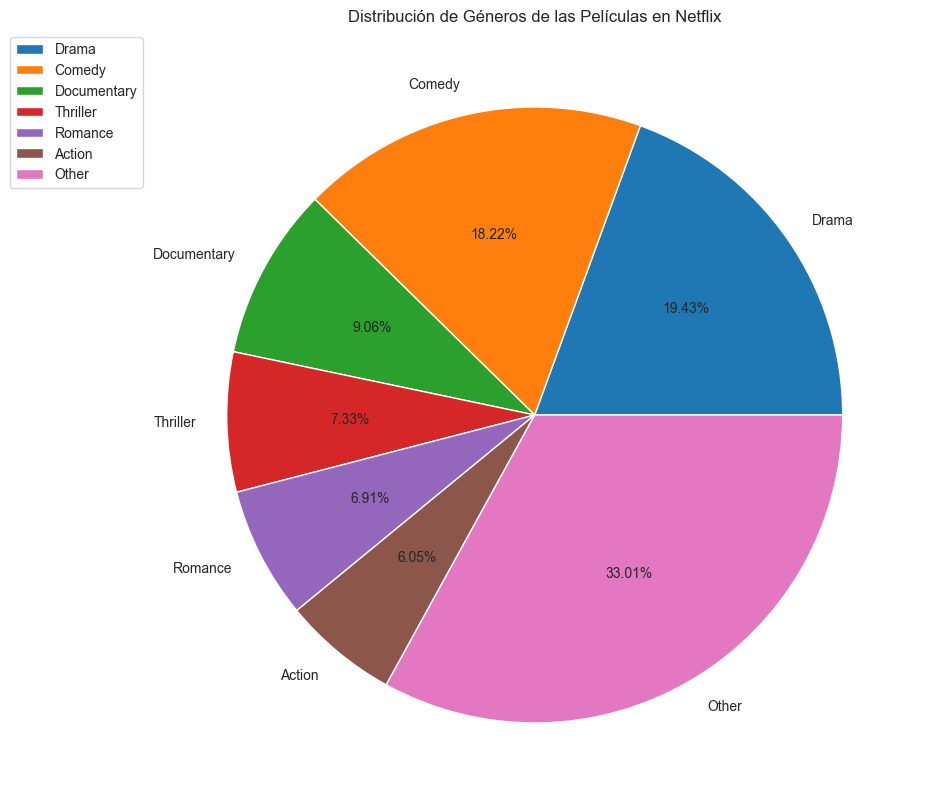

In [65]:
plt.figure(figsize=(10,10))

# declaring data 
data = porc_netflix_movies_genre_aux.values.tolist()
keys = porc_netflix_movies_genre_aux.index.tolist()
  
# plotting data on chart 
plt.pie(data, labels=keys,autopct='%.2f%%') 
plt.title("Distribución de Géneros de las Películas en Netflix")
plt.legend(loc = "best", bbox_to_anchor=(0, 1), fontsize='medium')
# displaying chart 
plt.show()

Tal y como se puede concluir del pie plot previo, los **géneros** que están **más presentes** en las **películas** de **Netflix** son, en primer lugar, '**Drama**', muy seguido de '**Comedia**'

### Series:

Repetimos el proceso realizado previamente para el caso de las las películas

In [ ]:
#Quitamos los corchetes y los espacios en blanco
netflix_series_spain["genre_ids"] = netflix_series_spain["genre_ids"].astype(str).replace({'[\[\]\s]': ''}, regex=True)
netflix_series_spain["genre_ids"]

<>:2: SyntaxWarning: invalid escape sequence '\['
<>:2: SyntaxWarning: invalid escape sequence '\['
C:\Users\tamar\AppData\Local\Temp\ipykernel_50552\2640439540.py:2: SyntaxWarning: invalid escape sequence '\['
  netflix_series_spain["genre_ids"] = netflix_series_spain["genre_ids"].astype(str).replace({'[\[\]\s]': ''}, regex=True)


0          10759,80,18
1        10759,18,9648
2       16,10759,10765
3                18,80
4          18,35,10751
             ...      
2477                  
2478                  
2479                  
2480                  
2481                  
Name: genre_ids, Length: 2482, dtype: object

Calculamos cuántas series hay en Netflix con género desconocido:

In [67]:
netflix_series_spain["genre_ids"].value_counts().sort_index()

genre_ids
                              33
10751                          2
10751,10762                    2
10751,10762,16,10759,10765     1
10751,10762,16,35              1
                              ..
99,80,10768                    1
99,80,9648                     6
99,9648                        2
99,9648,10764,10767            1
99,9648,80                     1
Name: count, Length: 416, dtype: int64

In [68]:
#No hay muchas series sin género, así que les adjudicamos el género desconocido
netflix_series_spain["genre_ids"] = netflix_series_spain["genre_ids"].astype(str).replace("", "Unknown")
netflix_series_spain["genre_ids"]

0          10759,80,18
1        10759,18,9648
2       16,10759,10765
3                18,80
4          18,35,10751
             ...      
2477           Unknown
2478           Unknown
2479           Unknown
2480           Unknown
2481           Unknown
Name: genre_ids, Length: 2482, dtype: object

In [69]:
series_genre_dict = dict(zip(series_genres["id"].astype(str).replace({'[\[\]\s]': ''}, regex=True), series_genres["name"]))
#Tenemos que añadir esta nueva clasificación para aquellas películas cuyo género no conocemos
series_genre_dict["Unknown"] = "Unknown"
series_genre_dict

<>:1: SyntaxWarning: invalid escape sequence '\['
<>:1: SyntaxWarning: invalid escape sequence '\['
C:\Users\tamar\AppData\Local\Temp\ipykernel_50552\765994367.py:1: SyntaxWarning: invalid escape sequence '\['
  series_genre_dict = dict(zip(series_genres["id"].astype(str).replace({'[\[\]\s]': ''}, regex=True), series_genres["name"]))


{'10759': 'Action & Adventure',
 '16': 'Animation',
 '35': 'Comedy',
 '80': 'Crime',
 '99': 'Documentary',
 '18': 'Drama',
 '10751': 'Family',
 '10762': 'Kids',
 '9648': 'Mystery',
 '10763': 'News',
 '10764': 'Reality',
 '10765': 'Sci-Fi & Fantasy',
 '10766': 'Soap',
 '10767': 'Talk',
 '10768': 'War & Politics',
 '37': 'Western',
 'Unknown': 'Unknown'}

In [ ]:
#Desglosamos los géneros de las series de Netflix
netflix_series_dummy = netflix_series_spain["genre_ids"].str.get_dummies(",")
netflix_series_dummy = netflix_series_dummy.rename(columns=series_genre_dict)
netflix_series_dummy

,Family,Action & Adventure,Kids,News,Reality,Sci-Fi & Fantasy,Soap,Talk,War & Politics,Animation,Drama,Comedy,Western,Crime,Mystery,Documentary,Unknown
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2478,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2479,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2480,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [71]:
#Apariciones de cada género para las series de Netflix
apars_gener_series_netflix= netflix_series_dummy.sum()
apars_gener_series_netflix

Family                 158
Action & Adventure     346
Kids                   218
News                     1
Reality                272
Sci-Fi & Fantasy       361
Soap                    16
Talk                    28
War & Politics          49
Animation              460
Drama                 1117
Comedy                 653
Western                  3
Crime                  418
Mystery                289
Documentary            437
Unknown                 33
dtype: int64

In [72]:
#Total de géneros informados en todas las series de Netflix
total_netflix_series_genre = apars_gener_series_netflix.sum()
total_netflix_series_genre

4859

In [73]:
porc_netflix_series_genre = (apars_gener_series_netflix/total_netflix_series_genre)*100
porc_netflix_series_genre.sort_values(ascending=False, inplace=True)
porc_netflix_series_genre

Drama                 22.988269
Comedy                13.438979
Animation              9.466969
Documentary            8.993620
Crime                  8.602593
Sci-Fi & Fantasy       7.429512
Action & Adventure     7.120807
Mystery                5.947726
Reality                5.597860
Kids                   4.486520
Family                 3.251698
War & Politics         1.008438
Unknown                0.679152
Talk                   0.576250
Soap                   0.329286
Western                0.061741
News                   0.020580
dtype: float64

Dibujamos el correspondiente gráfico:

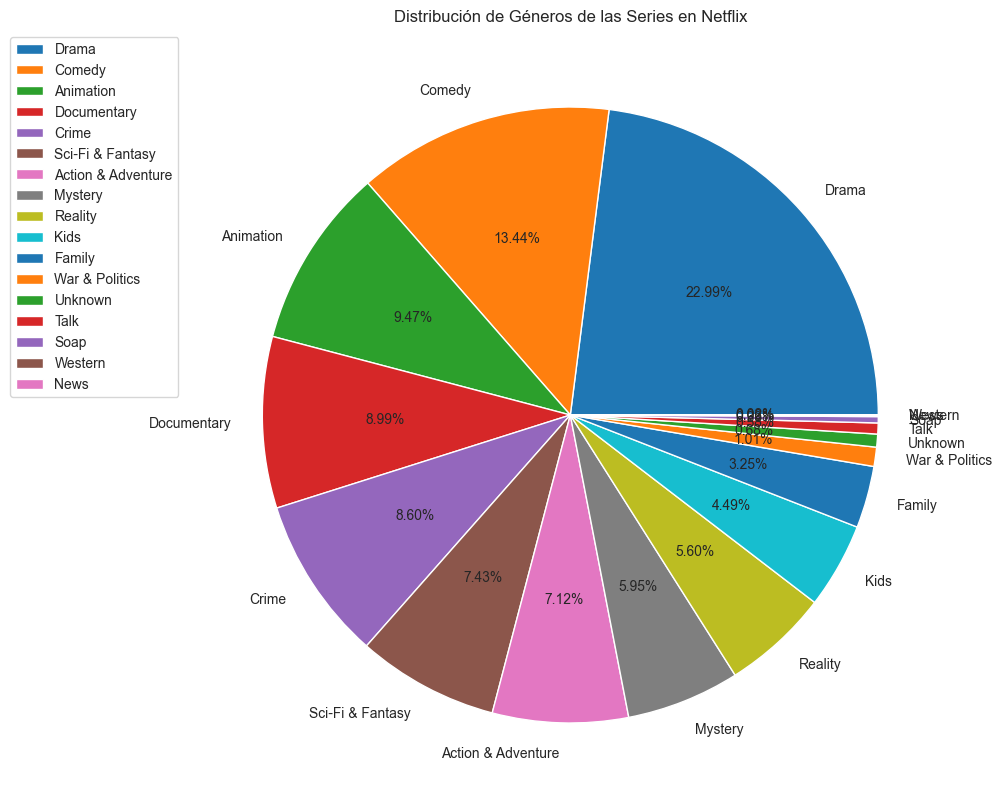

In [74]:
plt.figure(figsize=(10,10))

# declaring data 
data = porc_netflix_series_genre.values.tolist()
keys = porc_netflix_series_genre.index.tolist()
  
# plotting data on chart 
plt.pie(data, labels=keys,autopct='%.2f%%') 
plt.legend(loc = "best", bbox_to_anchor=(0, 1), fontsize='medium')
plt.title("Distribución de Géneros de las Series en Netflix")
# displaying chart 
plt.show()

De nuevo, genereamos un gráfico más simple de ver agrupando dentro de la categoría de "Otros" aquellos géneros cuyo porcentaje sea inferior al 6%:

In [75]:
#Calculamos la suma de todos los porcentajes inferiores al 6%
porc_other_netflix_series = porc_netflix_series_genre[porc_netflix_series_genre < 6].sum()
porc_other_netflix_series

21.95925087466557

In [76]:
#Generamos la siguiente serie con un único elemento (el valor es el porcentaje recién calculado y el 
# índice es ese género 'Otros' considerado para aquellos géneros menos relevantes)
other_netflix_series = pd.Series(data=porc_other_netflix_series, index = ['Other'])
other_netflix_series

Other    21.959251
dtype: float64

In [77]:
#Serie para mejor gráfico
porc_netflix_series_genre_aux = pd.concat([porc_netflix_series_genre[porc_netflix_series_genre > 6],other_netflix_series])
porc_netflix_series_genre_aux

Drama                 22.988269
Comedy                13.438979
Animation              9.466969
Documentary            8.993620
Crime                  8.602593
Sci-Fi & Fantasy       7.429512
Action & Adventure     7.120807
Other                 21.959251
dtype: float64

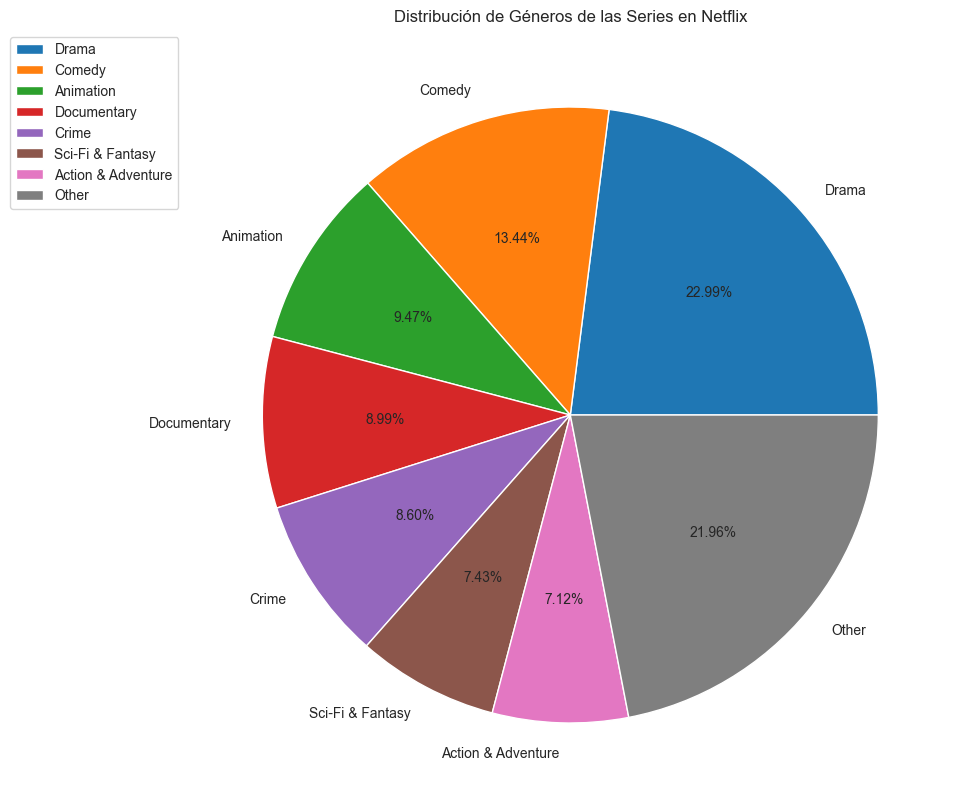

In [78]:
plt.figure(figsize=(10,10))

# declaring data 
data = porc_netflix_series_genre_aux.values.tolist()
keys = porc_netflix_series_genre_aux.index.tolist()
  
# plotting data on chart 
plt.pie(data, labels=keys,autopct='%.2f%%') 
plt.title("Distribución de Géneros de las Series en Netflix")
plt.legend(loc = "best", bbox_to_anchor=(0, 1), fontsize='medium')
# displaying chart 
plt.show()

En el caso de Netflix, los **géneros** que están **más presentes** en las **series** son, en primer lugar, '**Drama**', muy seguido de '**Comedia**'

**COINCIDEN PELÍCULAS Y SERIES**

## ¿Existe alguna relación entre la nota de cada género y su porcentaje de presencia en las plataformas?

### Películas:

Para facilitar desarrollos que haremos a continuación, definimos el listado de los géneros que pueden tener las películas:

In [79]:
movies_genres_list = list(movies_genres["name"])
movies_genres_list.append("Unknown") #Añadimos el valor correspondiente de desconocido comentado en anteriores análisis

#### Netflix:

Para conterstar correctamente a la pregunta planteada, vamos a hacer diversos cálculos que nos facilitarán dar una respuesta más visual: 

En primer lugar, partimos de la base de que tenemos una serie de tablas que nos permiten generar un dataset en el que incluir la información más importante de las películas (un registro por película):

In [80]:
info_pelis_netflix = pd.concat([netflix_movies_spain, netflix_movies_dummy], axis=1)
info_pelis_netflix

,original_title,title,id,genre_ids,release_date,popularity,vote_average,vote_count,original_language,adult,...,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
0,El hoyo 2,The Platform 2,1125510,"878,53,18,27",2024-09-27,2554.356,5.700,536,es,False,...,0,0,0,0,1,0,1,0,0,0
1,The Bad Guys: Haunted Heist,The Bad Guys: Haunted Heist,1329336,"16,35",2024-10-02,944.292,7.400,47,en,False,...,0,1,0,0,0,0,0,0,0,0
2,Strul,Trouble,1210794,"28,35,80",2024-10-02,917.854,7.100,77,sv,False,...,1,1,0,0,0,1,0,0,0,0
3,Bangkok Breaking: ฝ่านรกเมืองเทวดา,Bangkok Breaking: Heaven and Hell,1337309,"28,80,18,53",2024-09-26,664.257,6.500,29,th,False,...,1,0,0,0,1,1,0,0,0,0
4,Joker,Joker,475557,"80,53,18",2019-10-01,478.179,8.151,25441,en,False,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,Congreso Anyway,Congreso Anyway,999044,99,1993-04-01,0.001,0.000,0,nl,False,...,0,0,0,0,0,0,0,0,1,0
5612,Homo sapiens. Une nouvelle histoire de l'homme.,Homo Futurus: The Inside Story,920782,"99,36",2005-10-29,0.001,0.000,0,fr,False,...,0,0,1,0,0,0,0,0,1,0
5613,Wild Records!,Wild Records!,655704,Unknown,2001-02-03,0.001,0.000,0,pl,False,...,0,0,0,0,0,0,0,0,0,1
5614,Не все кошки серы,Not all the Cats are Gray,460784,Unknown,2004-01-01,0.001,0.000,0,ru,False,...,0,0,0,0,0,0,0,0,0,1


En realidad, para el desarrollo que vamos a realizar a continuación, no necesitamos toda esa información, así que descartamos lo prescindible:

In [81]:
info_pelis_netflix.drop(columns=["title", "genre_ids", "release_date", "popularity", "original_language", "adult"], inplace = True)
info_pelis_netflix

,original_title,id,vote_average,vote_count,Music,Romance,Family,War,TV Movie,Adventure,...,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
0,El hoyo 2,1125510,5.700,536,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,The Bad Guys: Haunted Heist,1329336,7.400,47,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Strul,1210794,7.100,77,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3,Bangkok Breaking: ฝ่านรกเมืองเทวดา,1337309,6.500,29,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,Joker,475557,8.151,25441,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5611,Congreso Anyway,999044,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5612,Homo sapiens. Une nouvelle histoire de l'homme.,920782,0.000,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
5613,Wild Records!,655704,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5614,Не все кошки серы,460784,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


En segundo lugar, para poder responder a la pregunta inicial, necesitamos conocer una estimación de la puntuación que tendría cada uno de los posibles géneros de películas en Netflix. No obstante, podríamos sacar esta nota infiriéndola de la relación que tenemos en la tabla anterior (```info_pelis_netflix```): **película - puntuación - géneros de la película**.

Sin embargo, no todas las películas tienen notas asignadas: Si nos fijamos en la siguiente agrupación, tenemos un total de 314 películas que no han sido votadas por los usuarios (```vote_count```=0) y, consecuentemente, su calificación es inexistente (```vote_average```=0). Pero hay que tener en cuenta que pueden existir películas que tengan una nota de 0 y, al menos, la clasificación de un usuario, **por lo que es importante borrar SÓLO las películas que no han sido votadas**:

In [82]:
info_pelis_netflix[["vote_average", "vote_count"]].value_counts()

vote_average  vote_count
0.000         0             314
2.000         1              47
6.000         1              41
10.000        1              30
8.000         1              28
                           ... 
6.234         374             1
              3962            1
6.239         647             1
              2015            1
6.500         339             1
Name: count, Length: 3540, dtype: int64

In [83]:
#A continuación mostramos los casos de películas que SÍ debemos tener en cuenta en nuestro estudio 
#por tener una calificación de 0 pero haber sido votadas
info_pelis_netflix[(info_pelis_netflix["vote_average"] == 0.000) & (info_pelis_netflix["vote_count"] != 0)] 

,original_title,id,vote_average,vote_count,Music,Romance,Family,War,TV Movie,Adventure,...,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
4186,Rätselhafte Hundemumien,724894,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4351,Viaje Todo Robado,772530,0.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4366,Det største i verden,280444,0.0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5401,Lungau – Wildnis im Herzen der Tauern,523327,0.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


De igual forma, no tendría sentido que hubiese películas sin votaciones de usuarios (```vote_count```=0) pero que, por el contrario, sí tuviesen una calificación asignada (```vote_average```!=0). Hemos encontrado que sí que existen casos así, si bien por ser sólo 2 tampoco los tendremos en cuenta para el análisis:

In [84]:
#Películas sin votaciones pero que tienen una calificación asignada (las descartamos del estudio)
info_pelis_netflix[(info_pelis_netflix["vote_count"] == 0)&(info_pelis_netflix["vote_average"] != 0)].sort_values(by="vote_average", ascending=False)

,original_title,id,vote_average,vote_count,Music,Romance,Family,War,TV Movie,Adventure,...,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
5280,Layali bala noom,175435,7.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3481,Chiếm Đoạt,1118343,3.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Así pues, de la tabla que contiene la información total, vamos a quedarnos con las películas que nos interesan (las votadas):

In [85]:
#Listado de películas votadas por los usuarios
info_pelis_netflix_votadas = info_pelis_netflix.drop(info_pelis_netflix[info_pelis_netflix["vote_count"] == 0].index)
info_pelis_netflix_votadas

,original_title,id,vote_average,vote_count,Music,Romance,Family,War,TV Movie,Adventure,...,Action,Comedy,History,Western,Thriller,Crime,Science Fiction,Mystery,Documentary,Unknown
0,El hoyo 2,1125510,5.700,536,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
1,The Bad Guys: Haunted Heist,1329336,7.400,47,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Strul,1210794,7.100,77,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,0
3,Bangkok Breaking: ฝ่านรกเมืองเทวดา,1337309,6.500,29,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
4,Joker,475557,8.151,25441,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5559,Story of... Cheese,1123357,7.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5560,Welcome to the Machine,1002110,10.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5561,The Intelligent Hand,987921,6.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5563,Endloser Horizont - Afrika 3D,181103,6.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Retomando nuestro objetivo de calcular una estimación de la puntuación que tendría cada uno de los posibles géneros de películas en Netflix, vamos a calcular la nota media de los mismos a partir de la de las películas, es decir, **para cada género vamos a ver qué películas están clasificadas bajo él y vamos a calcular su media**:

In [ ]:
netflix_movies_genre_vote_avg = []
for genre in movies_genres_list:
    vote_avg_genre = info_pelis_netflix_votadas[info_pelis_netflix_votadas[genre]==1]["vote_average"].mean()
    netflix_movies_genre_vote_avg.append(vote_avg_genre)

vote_avg_genre_movies_netflix = pd.Series(netflix_movies_genre_vote_avg, index = movies_genres_list)
vote_avg_genre_movies_netflix

Action             6.359140
Adventure          6.462524
Animation          6.615839
Comedy             6.060156
Crime              6.287855
Documentary        6.636895
Drama              6.248781
Family             6.267046
Fantasy            6.602831
History            6.731729
Horror             5.795051
Music              6.536394
Mystery            6.318498
Romance            6.239082
Science Fiction    6.327811
TV Movie           6.352839
Thriller           6.118815
War                6.575562
Western            5.886000
Unknown            5.435034
dtype: float64

Adicionalmente, para comprobar si la media es un estadístico fiable y que no hay outliers, calculamos la mediana:

In [ ]:
netflix_movies_genre_vote_median = []
for genre in movies_genres_list:
    vote_median_genre = info_pelis_netflix_votadas[info_pelis_netflix_votadas[genre]==1]["vote_average"].median()
    netflix_movies_genre_vote_median.append(vote_median_genre)

vote_median_genre_movies_netflix = pd.Series(netflix_movies_genre_vote_median, index = movies_genres_list)
vote_median_genre_movies_netflix

Action             6.4255
Adventure          6.5000
Animation          6.8000
Comedy             6.2000
Crime              6.4000
Documentary        6.8000
Drama              6.4000
Family             6.5000
Fantasy            6.6000
History            6.9000
Horror             6.0000
Music              6.8000
Mystery            6.3000
Romance            6.3365
Science Fiction    6.4210
TV Movie           6.4000
Thriller           6.2000
War                6.6000
Western            6.1515
Unknown            5.7000
dtype: float64

In [88]:
info_final_pelis_votadas_netflix = pd.concat([vote_avg_genre_movies_netflix, vote_median_genre_movies_netflix, porc_netflix_movies_genre, apars_gener_films_netflix, ], axis=1, join="inner").rename(columns = {
    0:"vote_avg_genre",
    1:"vote_median_genre", 
    2:"netflix_genre_percentage", 
    3: "genre_presence"
})
info_final_pelis_votadas_netflix

,vote_avg_genre,vote_median_genre,netflix_genre_percentage,genre_presence
Action,6.359140,6.4255,6.046512,663
Adventure,6.462524,6.5000,3.793890,416
Animation,6.615839,6.8000,2.754218,302
Comedy,6.060156,6.2000,18.221614,1998
Crime,6.287855,6.4000,5.481076,601
Documentary,6.636895,6.8000,9.056088,993
Drama,6.248781,6.4000,19.425445,2130
Family,6.267046,6.5000,3.793890,416
Fantasy,6.602831,6.6000,2.708618,297
History,6.731729,6.9000,1.595987,175


Puesto que las medias y las medianas son muy similares, los datos no tienen valores extremadamente altos/bajos y podemos usar las medias calculadas. Representamos así lo siguiente:

In [89]:
porcentaje_presencia = info_final_pelis_votadas_netflix["netflix_genre_percentage"].to_list() #Eje X de nuestra gráfica
nota_media = info_final_pelis_votadas_netflix["vote_avg_genre"].to_list() #Eje Y de nuestra gráfica
numero_apariciones = info_final_pelis_votadas_netflix["genre_presence"].to_list() #Tamaño de los puntos
genero = info_final_pelis_votadas_netflix.index.to_list() #Géneros de las películas

fig = px.scatter(
    x=porcentaje_presencia,
    y=nota_media,
    size=numero_apariciones, 
    color=genero, 
    labels={'x': 'Presencia de Géneros de Películas en Netflix (%)', 'y': 'Nota Media de Géneros de Películas en Netflix'},
    hover_name=genero, 
    width=1000,  
    height=500
)
fig.show()

### Series:
Repetimos el procedimiento previo usado para el caso de las películas:

In [90]:
#Listado de géneros de series
series_genres_list = list(series_genres["name"])
series_genres_list.append("Unknown")

#### Netflix:

In [91]:
info_series_netflix = pd.concat([netflix_series_spain, netflix_series_dummy], axis=1)
info_series_netflix

,original_name,name,id,genre_ids,first_air_date,popularity,vote_average,vote_count,original_language,adult,...,Talk,War & Politics,Animation,Drama,Comedy,Western,Crime,Mystery,Documentary,Unknown
0,Prison Break,Prison Break,2288,"10759,80,18",2005-08-29,985.135,8.079,5044,en,False,...,0,0,0,1,0,0,1,0,0,0
1,Outer Banks,Outer Banks,100757,"10759,18,9648",2020-04-15,1165.631,8.400,887,en,False,...,0,0,0,1,0,0,0,1,0,0
2,七つの大罪 黙示録の四騎士,The Seven Deadly Sins: Four Knights of the Apo...,218843,"16,10759,10765",2023-10-08,534.912,8.700,113,ja,False,...,0,0,1,0,0,0,0,0,0,0
3,Monsters,Monsters,225634,"18,80",2024-09-19,721.391,7.586,187,en,False,...,0,0,0,1,0,0,1,0,0,0
4,Klass 95: El poder de la belleza,KLASS 95: The Power of Beauty,262252,"18,35,10751",2024-08-20,388.277,6.800,6,es,False,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,Babies 24/7: The Maternity Ward,Babies 24/7: The Maternity Ward,215052,Unknown,2022-11-22,0.140,2.000,1,en,False,...,0,0,0,0,0,0,0,0,0,1
2478,Curso del 63,Curso del 63,121657,Unknown,2009-10-06,0.019,0.000,0,es,False,...,0,0,0,0,0,0,0,0,0,1
2479,Chi è Jack lo Squartatore,Chi è Jack lo Squartatore,250132,Unknown,2020-03-10,0.036,0.000,0,it,False,...,0,0,0,0,0,0,0,0,0,1
2480,Chi era… - Lo show,Chi era… - Lo show,249088,Unknown,2018-07-11,0.015,0.000,0,it,False,...,0,0,0,0,0,0,0,0,0,1


In [92]:
info_series_netflix.drop(columns=["name", "genre_ids", "first_air_date", "popularity", "original_language", "adult"], inplace = True)
info_series_netflix

,original_name,id,vote_average,vote_count,Family,Action & Adventure,Kids,News,Reality,Sci-Fi & Fantasy,...,Talk,War & Politics,Animation,Drama,Comedy,Western,Crime,Mystery,Documentary,Unknown
0,Prison Break,2288,8.079,5044,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,Outer Banks,100757,8.400,887,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,七つの大罪 黙示録の四騎士,218843,8.700,113,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,Monsters,225634,7.586,187,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,Klass 95: El poder de la belleza,262252,6.800,6,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,Babies 24/7: The Maternity Ward,215052,2.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2478,Curso del 63,121657,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2479,Chi è Jack lo Squartatore,250132,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2480,Chi era… - Lo show,249088,0.000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Para poder hacer los cálculos análogos al caso de las películas de Netflix, vamos a descartar aquellas series que no hayan sido votadas por los usuarios:

In [93]:
#Listado de series votadas por los usuarios
info_series_netflix_votadas = info_series_netflix.drop(info_series_netflix[info_series_netflix["vote_count"] == 0].index)
info_series_netflix_votadas

,original_name,id,vote_average,vote_count,Family,Action & Adventure,Kids,News,Reality,Sci-Fi & Fantasy,...,Talk,War & Politics,Animation,Drama,Comedy,Western,Crime,Mystery,Documentary,Unknown
0,Prison Break,2288,8.079,5044,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,Outer Banks,100757,8.400,887,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
2,七つの大罪 黙示録の四騎士,218843,8.700,113,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,Monsters,225634,7.586,187,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,Klass 95: El poder de la belleza,262252,6.800,6,1,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471,베이비 주,206791,2.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2472,Escalona,152284,2.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2473,Quarantine Tales,128480,4.000,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2475,Magic for Humans by Mago Pop,211177,2.000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [94]:
#Calculamos las medias y construimos la serie que las asocia a cada género
netflix_series_genre_vote_avg = []
for genre in series_genres_list:
    vote_avg_genre = info_series_netflix_votadas[info_series_netflix_votadas[genre]==1]["vote_average"].mean()
    netflix_series_genre_vote_avg.append(vote_avg_genre)
vote_avg_genre_series_netflix = pd.Series(netflix_series_genre_vote_avg, index = series_genres_list)

#Calculamos las medianas y construimos la serie que las asocia a cada género
netflix_series_genre_vote_median = []
for genre in series_genres_list:
    vote_median_genre = info_series_netflix_votadas[info_series_netflix_votadas[genre]==1]["vote_average"].median()
    netflix_series_genre_vote_median.append(vote_median_genre)
vote_median_genre_series_netflix = pd.Series(netflix_series_genre_vote_median, index = series_genres_list);

In [95]:
#Construimos la tabla con los datos que vamos a graficar
info_final_series_votadas_netflix = pd.concat([vote_avg_genre_series_netflix, vote_median_genre_series_netflix, porc_netflix_series_genre, apars_gener_series_netflix, ], axis=1, join="inner").rename(columns = {
    0:"vote_avg_genre",
    1:"vote_median_genre", 
    2:"netflix_genre_percentage", 
    3: "genre_presence"
})
info_final_series_votadas_netflix

,vote_avg_genre,vote_median_genre,netflix_genre_percentage,genre_presence
Action & Adventure,7.456438,7.5000,7.120807,346
Animation,7.268742,7.4030,9.466969,460
Comedy,7.060136,7.2000,13.438979,653
Crime,7.098177,7.1000,8.602593,418
Documentary,6.900321,7.0000,8.993620,437
Drama,7.229033,7.3000,22.988269,1117
Family,7.219551,7.3560,3.251698,158
Kids,6.933209,7.1000,4.486520,218
Mystery,7.196059,7.2000,5.947726,289
News,7.100000,7.1000,0.020580,1


In [96]:
#De nuevo, medias y medianas no varían mucho así que procedemos a dibujar la gráfica
porcentaje_presencia = info_final_series_votadas_netflix["netflix_genre_percentage"].to_list() #Eje X de nuestra gráfica
nota_media = info_final_series_votadas_netflix["vote_avg_genre"].to_list() #Eje Y de nuestra gráfica
numero_apariciones = info_final_series_votadas_netflix["genre_presence"].to_list() #Tamaño de los puntos
genero = info_final_series_votadas_netflix.index.to_list() #Géneros de las series

fig = px.scatter(
    x=porcentaje_presencia,
    y=nota_media,
    size=numero_apariciones, 
    color=genero, 
    labels={'x': 'Presencia de Géneros de Series en Netflix (%)', 'y': 'Nota Media de Géneros de Series en Netflix'},
    hover_name=genero, 
    width=1000,  
    height=500
)
fig.show()